In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
grey_color = plt.cm.Greys(np.linspace(0.2, 0.8, 10))

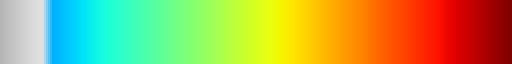

In [4]:
colors1 = plt.cm.Greys_r(np.linspace(0.6, 0.8, 5))
colors2 = plt.cm.jet(np.linspace(0.3, 1, 45))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [5]:
stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')

In [6]:
data= xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/era5_0.25deg_BL_2Dhistogram.wbwl.landsea.2001-2010.nc')
samples_clim_ocean = data.sel(surface_type='ocean').samples
samples_clim_land = data.sel(surface_type='land').samples

In [7]:
%%time
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.3deg.full.nc'.format(year))
    if n == 0:
        samples_all_ocean = data.samples
    else:
        samples_all_ocean = samples_all_ocean + data.samples

CPU times: user 117 ms, sys: 40.3 ms, total: 158 ms
Wall time: 194 ms


#### fraction of phase occurrence for a given combination of BL,cape and BL,subsat
- based on 3-deg box mean: N_phase/N_total 
- using grids will have more MCS-related grid points as an MCS grow (extensive CCS area)

In [8]:
%%time
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
   
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.3deg.full.nc'.format(year))
    data2 = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.land.3deg.full.nc'.format(year))
    if n == 0:
        samples_all_ocean = data.samples + data2.samples
    else:
        samples_all_ocean += data.samples + data2.samples

CPU times: user 223 ms, sys: 58.8 ms, total: 282 ms
Wall time: 317 ms


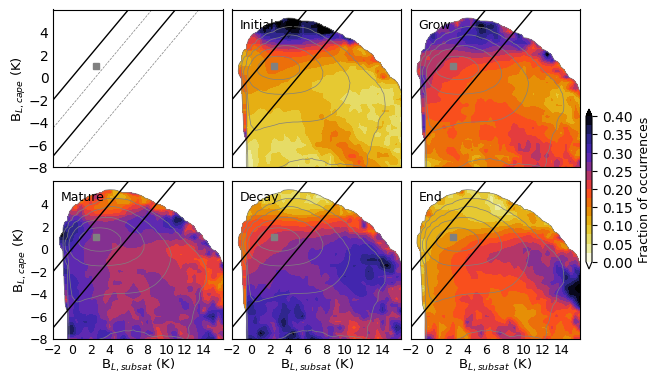

In [9]:
samples_3degmean = samples_all_ocean.sel(area_type='mcs').sum('duration_type')
dbl = 0.05
bins_cape = samples_3degmean.bins_cape
bins_subsat = samples_3degmean.bins_subsat
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label) in enumerate(zip([ax2,ax3,ax4,ax5,ax6]
                                        ,['Initial','Grow','Mature','Decay','End']
                                        ,['(a)','(b)','(c)','(d)','(e)'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    
    cp = ax.contourf(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, levels=np.arange(0,0.425,0.025), 
                       cmap='CMRmap_r', zorder=2, extend='both')
    cp.cmap.set_over('k')
    
    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour 
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['grey'], levels=[2,3,4,5,6], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
    #ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12,14])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-8,6])
    ax.set_xlim([-2,16])   

ax1.tick_params('both', length=0, width=1, which='major')

ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_yticks([-8,-6,-4,-2,0,2,4])
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])

track_num = int(samples_all_ocean.sel(area_type='amean',phase='CCS').sum().values)
#plt.suptitle('Fraction of occurrences, MCS grids, Ocean', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.4,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)

(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
ax1.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')

ax1.set_ylim([-8,6])
ax1.set_xlim([-2,16])
plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSgridsBL_fraction_occurrence.ocean.rotate.pdf',
#       bbox_inches='tight',transparent=False)

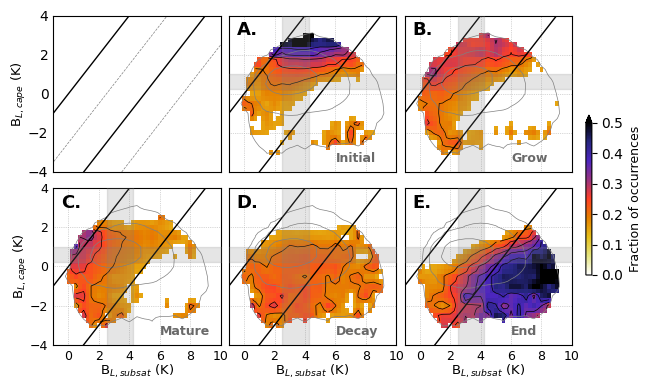

In [13]:
samples_3degmean = samples_all_ocean.sel(area_type='amean').sum('duration_type')
dbl = 0.25
bins_cape = samples_3degmean.bins_cape
bins_subsat = samples_3degmean.bins_subsat
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

# get 25th and 75th line
test = samples_allphases.sum('bins_cape')
total_sum = test.sum()
pcent = np.cumsum(test)/total_sum
idx_25th = np.where(pcent > 0.25)[0][0]    
subsat_25th = samples_allphases.bins_subsat[idx_25th]
idx_75th = np.where(pcent > 0.75)[0][0]
subsat_75th = samples_allphases.bins_subsat[idx_75th]

# get 25th and 75th line
test = samples_allphases.sum('bins_subsat')
total_sum = test.sum()
pcent = np.cumsum(test)/total_sum
idx_25th = np.where(pcent > 0.25)[0][0]    
cape_25th = samples_allphases.bins_cape[idx_25th]
idx_75th = np.where(pcent > 0.75)[0][0]
cape_75th = samples_allphases.bins_cape[idx_75th]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label_str) in enumerate(zip([ax2,ax3,ax4,ax5,ax6]
                                        ,['Initial','Grow','Mature','Decay','End']
                                        ,['A.','B.','C.','D.','E.'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    fract_phase = fract_phase.where(fract_phase >= 0.15)
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5,
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    cf = ax.contour(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, levels=[0.2,0.25,0.3,0.35,0.4], 
                       colors=['k'], linewidths=0.5, zorder=3)
    #ax.clabel(cf,[0.2,0.25,0.3], inline=True, inline_spacing=0, fontsize=6, fmt='%1.1f')

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour of joint histogram
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['grey'], levels=[2,3,4,5], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    #ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(6,-3.5,'{}'.format(phase),fontsize=9,color='dimgrey',fontweight='bold')
    ax.text(-0.5,3,'{}'.format(label_str),fontsize=13,fontweight='bold',color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12,14])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-4,4])
    ax.set_xlim([-1,10])   

ax1.tick_params('both', length=0, width=1, which='major')

ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_yticks([-8,-6,-4,-2,0,2,4])
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
#plt.suptitle('Fraction of occurrences, MCS grids, Ocean', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.2,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)
#ax1.text(-0.5,3,'A.',fontsize=13,fontweight='bold',color='k')

# get mode
(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
#ax1.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
# plot mode location lines and 25th, 75th percentile for each panel
for ax in [ax2,ax3,ax4,ax5,ax6]:
    #ax.plot(subsat_mode.values*np.ones(len(np.arange(-12,12))), np.arange(-12,12), '--', lw=0.5, color='grey')
    #ax.plot(np.arange(-12,12), cape_mode.values*np.ones(len(np.arange(-12,12))), '--', lw=0.5, color='grey')
    y = np.arange(-12,12)
    a = subsat_25th.values*np.ones(len(y))
    b = subsat_75th.values*np.ones(len(y))
    x = np.arange(-12,12)
    c = cape_25th.values*np.ones(len(x))
    d = cape_75th.values*np.ones(len(x))  
    ax.fill_betweenx(y, a, b, where=(a < b), alpha=0.2, zorder=3, color='grey')
    ax.fill_between(x, c, d, where=(c < d), alpha=0.2, zorder=3, color='grey')
    
ax1.set_ylim([-4,4])
ax1.set_xlim([-1,10])
plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig3_MCSgridsBL_fraction_occurrence.all.ameanBL0.1.pdf',
#      bbox_inches='tight',transparent=False)

#### over land

In [7]:
%%time
year_list = np.arange(2001,2021)

for n,year in enumerate(year_list):
    
    data = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.3deg.full.nc'.format(year))
    if n == 0:
        samples_all_land = data.samples
    else:
        samples_all_land = samples_all_land + data.samples

CPU times: user 1.1 s, sys: 152 ms, total: 1.26 s
Wall time: 1.36 s


In [8]:
samples_all_land.sel(area_type='amean', phase=['Initial','End','Grow','Mature','Decay']).sum()/5

<xarray.DataArray 'samples' ()> Size: 8B
array(56464.8)
Coordinates:
    area_type  <U5 20B 'amean'

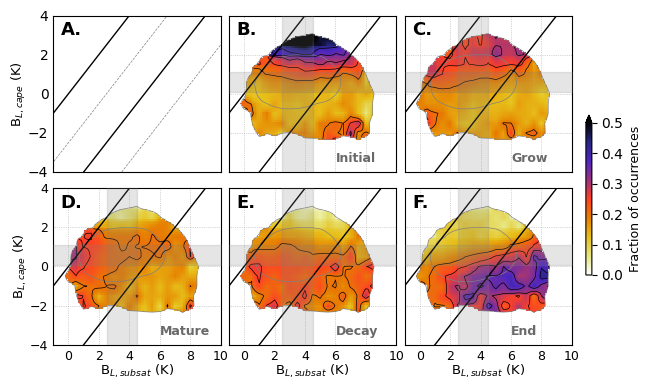

In [180]:
samples_3degmean = samples_all_land.sel(area_type='amean').sum('duration_type')
dbl = 0.1
bins_cape = samples_3degmean.bins_cape
bins_subsat = samples_3degmean.bins_subsat
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
samples_allphases = samples_3degmean.sel(phase=['Initial','End','Grow','Mature','Decay']).sum('phase')

# get 25th and 75th line
test = samples_allphases.sum('bins_cape')
total_sum = test.sum()
pcent = np.cumsum(test)/total_sum
idx_25th = np.where(pcent > 0.25)[0][0]    
subsat_25th = samples_allphases.bins_subsat[idx_25th]
idx_75th = np.where(pcent > 0.75)[0][0]
subsat_75th = samples_allphases.bins_subsat[idx_75th]

# get 25th and 75th line
test = samples_allphases.sum('bins_subsat')
total_sum = test.sum()
pcent = np.cumsum(test)/total_sum
idx_25th = np.where(pcent > 0.25)[0][0]    
cape_25th = samples_allphases.bins_cape[idx_25th]
idx_75th = np.where(pcent > 0.75)[0][0]
cape_75th = samples_allphases.bins_cape[idx_75th]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label_str) in enumerate(zip([ax2,ax3,ax4,ax5,ax6]
                                        ,['Initial','Grow','Mature','Decay','End']
                                        ,['B.','C.','D.','E.','F.'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    fract_phase = samples_sub/samples_allphases
    tmp = samples_3degmean.sum('phase')
    fract_phase = fract_phase.where(samples_allphases >= 100) # samples greater than 100
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5,
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    cf = ax.contour(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, levels=[0.2,0.25,0.3,0.35,0.4], 
                       colors=['k'], linewidths=0.5, zorder=3)
    #ax.clabel(cf,[0.2,0.25,0.3], inline=True, inline_spacing=0, fontsize=6, fmt='%1.1f')

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour of joint histogram
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['grey'], levels=[2,3,4,5], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    #ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(6,-3.5,'{}'.format(phase),fontsize=9,color='dimgrey',fontweight='bold')
    ax.text(-0.5,3,'{}'.format(label_str),fontsize=13,fontweight='bold',color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12,14])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-4,4])
    ax.set_xlim([-1,10])   

ax1.tick_params('both', length=0, width=1, which='major')

ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_yticks([-8,-6,-4,-2,0,2,4])
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
#plt.suptitle('Fraction of occurrences, MCS grids, Ocean', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.2,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)
ax1.text(-0.5,3,'A.',fontsize=13,fontweight='bold',color='k')

# get mode
(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
#ax1.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
# plot mode location lines and 25th, 75th percentile for each panel
for ax in [ax2,ax3,ax4,ax5,ax6]:
    #ax.plot(subsat_mode.values*np.ones(len(np.arange(-12,12))), np.arange(-12,12), '--', lw=0.5, color='grey')
    #ax.plot(np.arange(-12,12), cape_mode.values*np.ones(len(np.arange(-12,12))), '--', lw=0.5, color='grey')
    y = np.arange(-12,12)
    a = subsat_25th.values*np.ones(len(y))
    b = subsat_75th.values*np.ones(len(y))
    x = np.arange(-12,12)
    c = cape_25th.values*np.ones(len(x))
    d = cape_75th.values*np.ones(len(x))  
    ax.fill_betweenx(y, a, b, where=(a < b), alpha=0.2, zorder=3, color='grey')
    ax.fill_between(x, c, d, where=(c < d), alpha=0.2, zorder=3, color='grey')
    
ax1.set_ylim([-4,4])
ax1.set_xlim([-1,10])
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig3_MCSgridsBL_fraction_occurrence.land.ameanBL0.1.pdf',
     bbox_inches='tight',transparent=False)

#### A new fraction where all bin cells in each panel sums to one

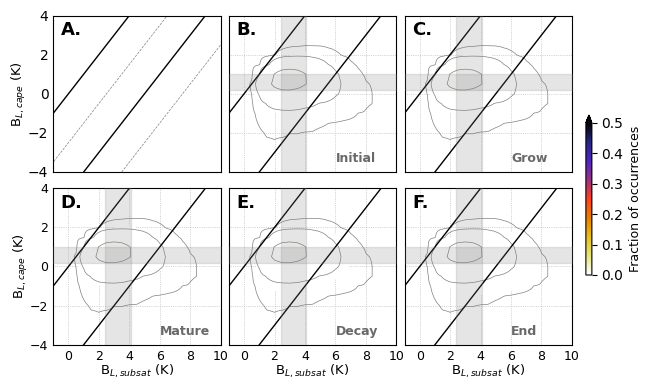

In [10]:
samples_3degmean = samples_all_land.sel(area_type='amean').sum('duration_type')
dbl = 0.1
bins_cape = samples_3degmean.bins_cape
bins_subsat = samples_3degmean.bins_subsat
samples_3degmean = samples_3degmean.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

# get 25th and 75th line
test = samples_allphases.sum('bins_cape')
total_sum = test.sum()
pcent = np.cumsum(test)/total_sum
idx_25th = np.where(pcent > 0.25)[0][0]    
subsat_25th = samples_allphases.bins_subsat[idx_25th]
idx_75th = np.where(pcent > 0.75)[0][0]
subsat_75th = samples_allphases.bins_subsat[idx_75th]

# get 25th and 75th line
test = samples_allphases.sum('bins_subsat')
total_sum = test.sum()
pcent = np.cumsum(test)/total_sum
idx_25th = np.where(pcent > 0.25)[0][0]    
cape_25th = samples_allphases.bins_cape[idx_25th]
idx_75th = np.where(pcent > 0.75)[0][0]
cape_75th = samples_allphases.bins_cape[idx_75th]

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))

for p,(ax,phase,label_str) in enumerate(zip([ax2,ax3,ax4,ax5,ax6]
                                        ,['Initial','Grow','Mature','Decay','End']
                                        ,['B.','C.','D.','E.','F.'])):
    
    samples_sub = samples_3degmean.sel(phase=phase)
    fract_phase = samples_sub/samples_sub.sum()
    fract_phase = fract_phase.where(samples_sub >= 100) # samples greater than 100
    
    cp = ax.pcolormesh(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, vmin=0, vmax=0.5,
                       cmap='CMRmap_r', zorder=2)
    cp.cmap.set_over('k')
    cf = ax.contour(fract_phase.bins_subsat, fract_phase.bins_cape, fract_phase, levels=[0.2,0.25,0.3,0.35,0.4], 
                       colors=['k'], linewidths=0.5, zorder=3)
    #ax.clabel(cf,[0.2,0.25,0.3], inline=True, inline_spacing=0, fontsize=6, fmt='%1.1f')

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Fraction of occurrences',fontsize=9)
    
    # add contour of joint histogram
    ax.contour(samples_allphases.bins_subsat, samples_allphases.bins_cape, np.log10(samples_allphases), 
               colors=['grey'], levels=[2,3,4,5], linewidths=0.5)
    
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
    
    # add cape-subsat mode of all phases
    (idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
    cape_mode = samples_allphases.bins_cape[idx]
    subsat_mode = samples_allphases.bins_subsat[idy] 
    #ax.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
    
    ## configuration of tick, labels
    ax.text(6,-3.5,'{}'.format(phase),fontsize=9,color='dimgrey',fontweight='bold')
    ax.text(-0.5,3,'{}'.format(label_str),fontsize=13,fontweight='bold',color='k')
    ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12,14])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=0, width=1, which='major')
    
    # set x-y domain 
    ax.set_ylim([-4,4])
    ax.set_xlim([-1,10])   

ax1.tick_params('both', length=0, width=1, which='major')

ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax1.set_yticks([-8,-6,-4,-2,0,2,4])
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
#plt.suptitle('Fraction of occurrences, MCS grids, Ocean', x=0.54, y=0.94, fontsize=9.5, fontweight='bold')
plt.tight_layout(h_pad=0.2,w_pad=0.02)

#====== schematic part for axis 2 =======
# add buoyancy reference 
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='grey', ls='--',lw=0.5)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='-',lw=1)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-7.5, color='grey', ls='--',lw=0.5)
ax1.text(-0.5,3,'A.',fontsize=13,fontweight='bold',color='k')

# get mode
(idx,idy) = unravel_index(samples_allphases.argmax(), samples_allphases.shape)
cape_mode = samples_allphases.bins_cape[idx]
subsat_mode = samples_allphases.bins_subsat[idy] 
#ax1.plot(subsat_mode, cape_mode, 's', ms=4, color='grey')
# plot mode location lines and 25th, 75th percentile for each panel
for ax in [ax2,ax3,ax4,ax5,ax6]:
    #ax.plot(subsat_mode.values*np.ones(len(np.arange(-12,12))), np.arange(-12,12), '--', lw=0.5, color='grey')
    #ax.plot(np.arange(-12,12), cape_mode.values*np.ones(len(np.arange(-12,12))), '--', lw=0.5, color='grey')
    y = np.arange(-12,12)
    a = subsat_25th.values*np.ones(len(y))
    b = subsat_75th.values*np.ones(len(y))
    x = np.arange(-12,12)
    c = cape_25th.values*np.ones(len(x))
    d = cape_75th.values*np.ones(len(x))  
    ax.fill_betweenx(y, a, b, where=(a < b), alpha=0.2, zorder=3, color='grey')
    ax.fill_between(x, c, d, where=(c < d), alpha=0.2, zorder=3, color='grey')
    
ax1.set_ylim([-4,4])
ax1.set_xlim([-1,10])
plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig3_MCSgridsBL_fraction_occurrence.land.ameanBL0.1.pdf',
#     bbox_inches='tight',transparent=False)

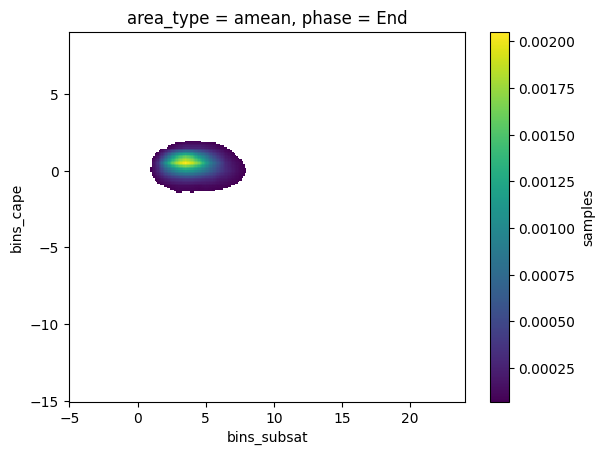

In [12]:
fract_phase.plot()